# ⏱ High-level `TimedModule` API

## Constructing a `TimedModule`

In [1]:
# - Useful imports
import numpy as np

try:
    from rich import print
except:
    pass

# - Import a TimedModule from Rockpool
from rockpool.nn.layers import FFRateEuler

# - Construct the TimedModule
Nin = 1
Nout = 5
dt = 1e-3
tmod = FFRateEuler(weights = np.random.rand(Nin, Nout), dt = dt)
print(tmod)

## Evolving a `TimedModule`

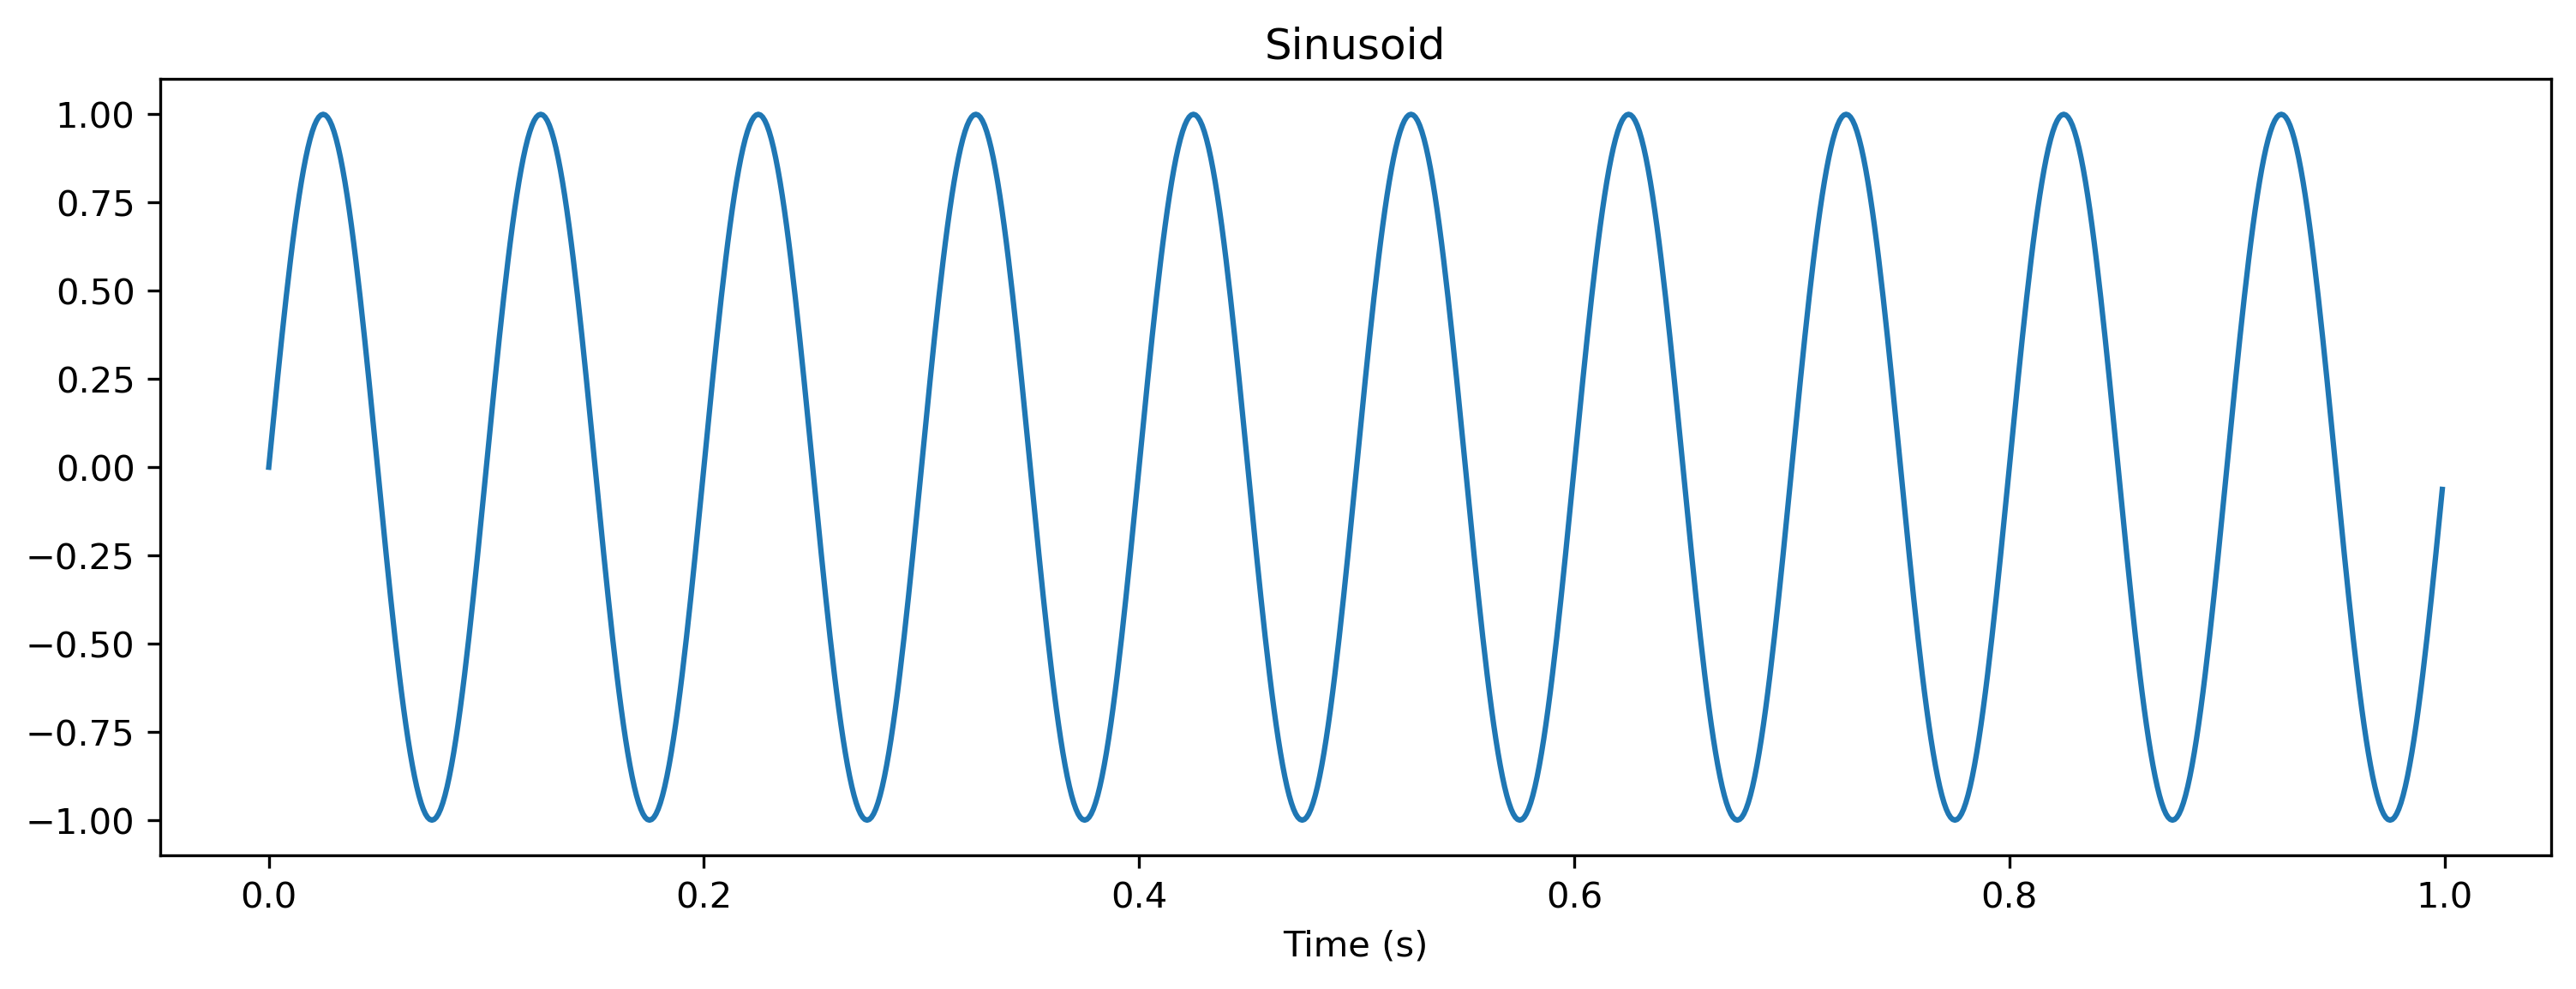

In [2]:
# - Import time-series handling classes
from rockpool import TSContinuous

# - Import and configure matplotlib for plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 300

# - Create a sinusoidal input signal
T = 1000
omega = 10
time_base = np.arange(T) * dt
ts_sin = TSContinuous.from_clocked(
    np.sin(time_base * 2 * np.pi * omega),
    dt = dt,
    periodic = True,
    name = 'Sinusoid',
)
ts_sin.plot();

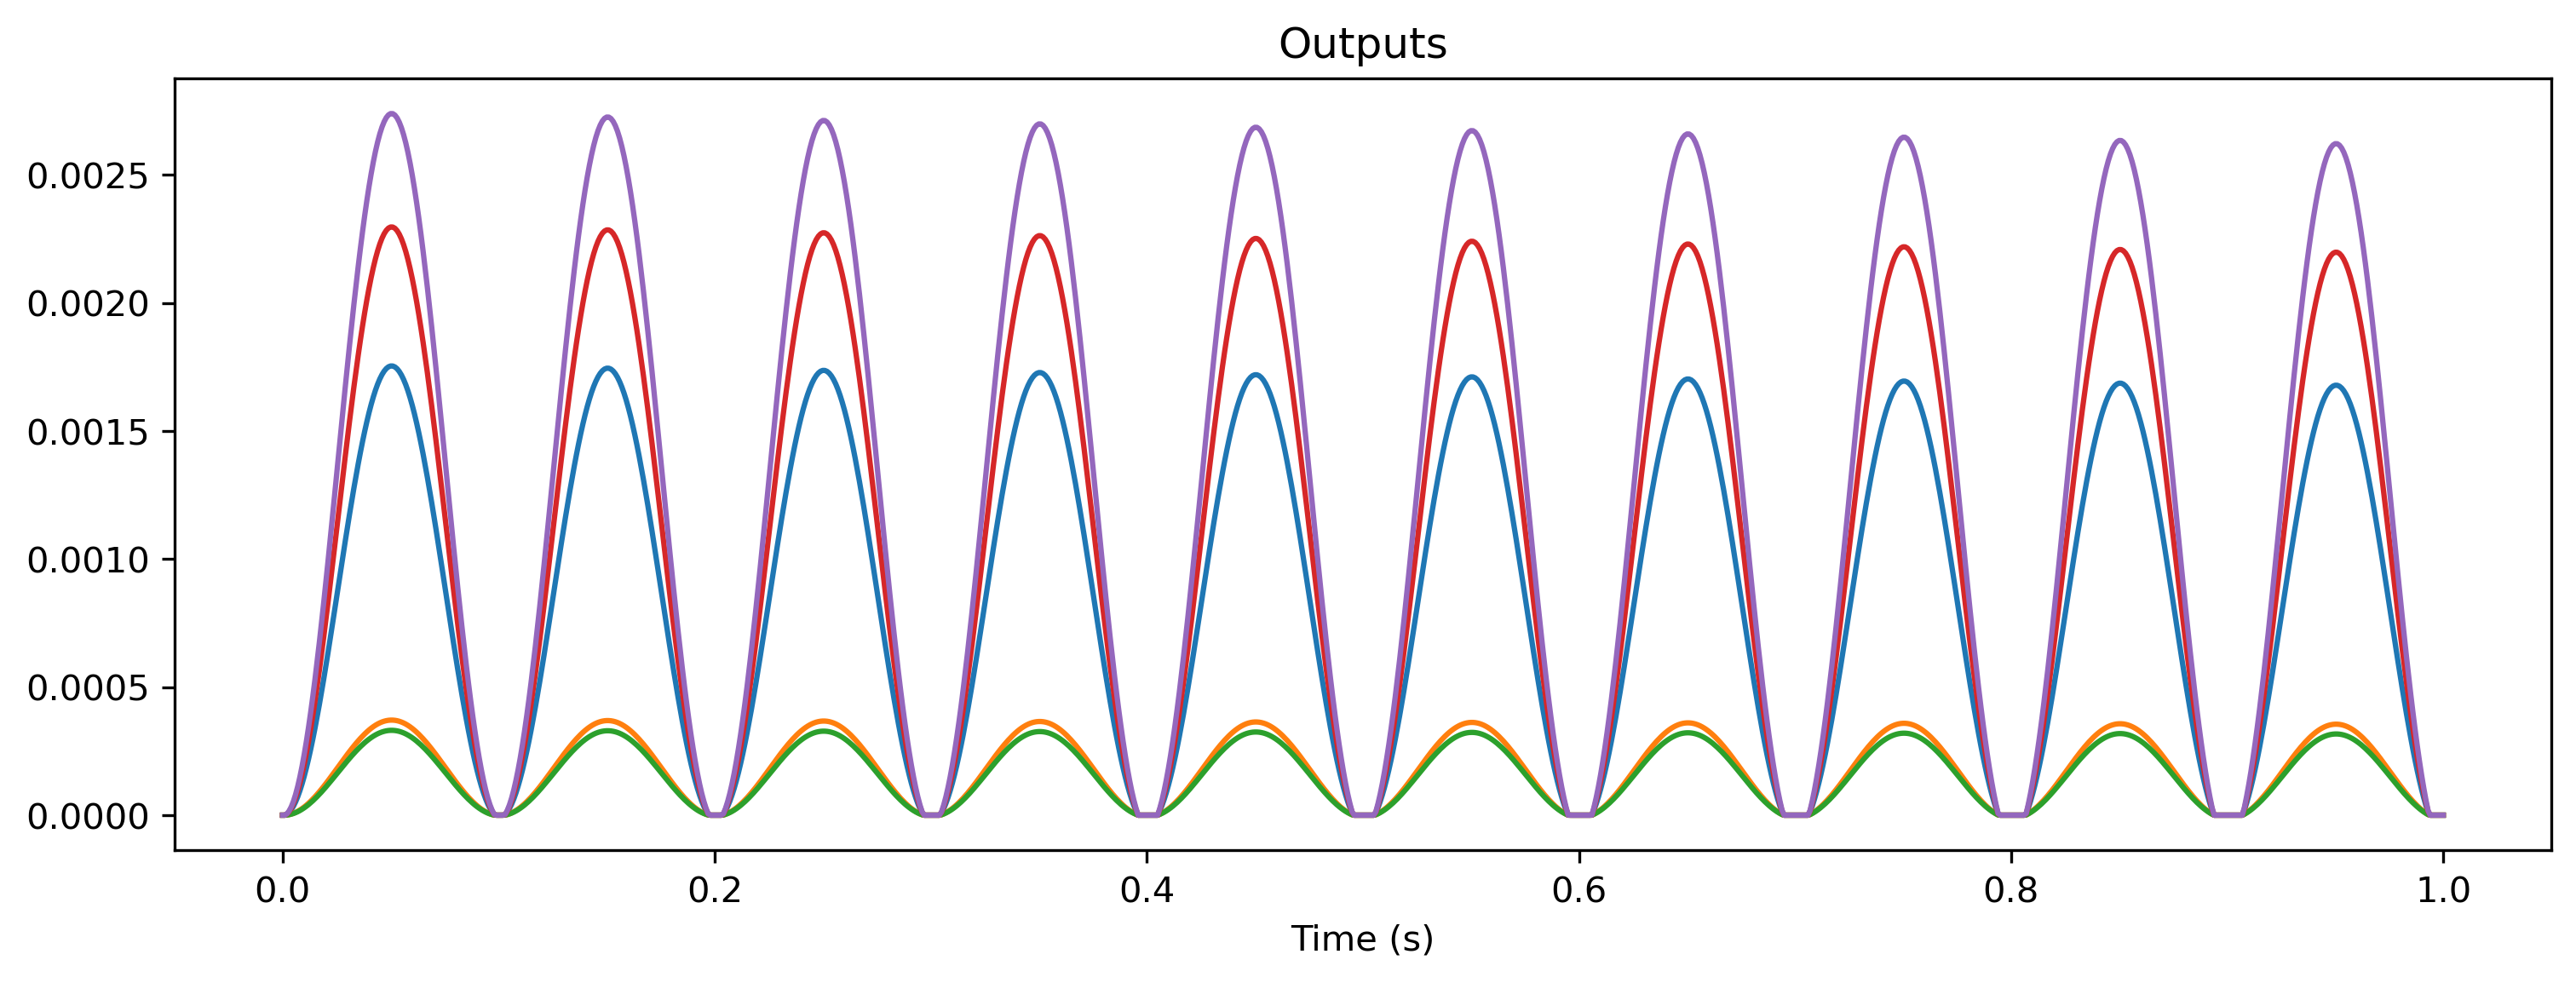

In [3]:
# - Evolve the TimedModule
output_ts, _, _ = tmod(ts_sin)
plt.figure();
print(output_ts);
output_ts.plot();

## Inspecting a `TimedModule`

In [4]:
# - Examine the parameters
print('Parameters:', tmod.parameters())

# - Examine the state
print('State:', tmod.state())

# - Examine the simulation parameters
print('Simulation parameters:', tmod.simulation_parameters())

# - `TimedModules` also have time
print('Time:', tmod.t)

## Building a network using nested `TimedModule` s

In [5]:
# - Import the base class and a TimedModule to use as a submodule
from rockpool.nn.modules import TimedModule
from rockpool.parameters import Parameter
from rockpool.nn.layers import FFRateEuler
from rockpool import TimeSeries

# - Define a new TimedModule
class ffwd_tmod_net(TimedModule):
    # - Provide an `__init__` method to specify required parameters and modules
    #   Here you check, define and initialise whatever parameters and
    #   state you need for your module.
    def __init__(self,
                 shape,
                 *args,
                 **kwargs,
                ):
        # - Call superclass initialisation
        #   This is always required for a `Module` class
        super().__init__(shape = shape, *args, **kwargs)

        # - Specify weights attribute
        #   We need a weights matrix for our input weights.
        #   We specify the shape explicitly, and provide an initialisation function.
        #   We also specify a family for the parameter, "weights". This is used to
        #   query parameters conveniently, and is a good idea to provide.
        self.w_ffwd = Parameter(shape = self.shape[0:2],
                                init_func = lambda s: np.zeros(s),
                                family = 'weights',
                               )
    
        # - Specify and add submodules
        #   These will be the neurons in our layer, to receive the weighted
        #   input signals. This sub-module will be automatically configured
        #   internally, to specify the required state and parameters
        self.neurons1 = FFRateEuler(np.zeros(self.shape[1:3]))
        self.neurons2 = FFRateEuler(np.zeros(self.shape[2:4]))
        
    # - The `evolve` method contains the internal logic of your module
    #   `evolve` takes care of passing data in and out of the module,
    #   and between sub-modules if present.
    def evolve(self,
               ts_input: TimeSeries,
               duration: float,
               num_timesteps: int,
               record: bool = False,
               *args, **kwargs):
        # - Pass input data through the input weights
        x0 = ts_input @ self.w_ffwd
        
        # - Pass the signals through the neurons
        x1, _, _ = self.neurons1(x0)
        x2, _, _ = self.neurons2(x1)
        
        # - Return the module output
        return x2, {}, {}

In [6]:
Nin = 3
Nout = 1
dt = 1

tmod = ffwd_tmod_net((Nin, 5, 7, Nout), dt = dt)
print(tmod)

In [7]:
# - Examine the nested parameters of the TimedModule
print(tmod.parameters())

In [8]:
# - Set the weights to something non-zero
p = tmod.parameters()
p['w_ffwd'] = np.random.normal(size = p['w_ffwd'].shape) + 1
p['neurons1']['weights'] = np.random.normal(size = p['neurons1']['weights'].shape) + 1
p['neurons2']['weights'] = np.random.normal(size = p['neurons2']['weights'].shape) + 1

# - Assign the new parameters
tmod.set_attributes(p)
print('Weights:', tmod.parameters())

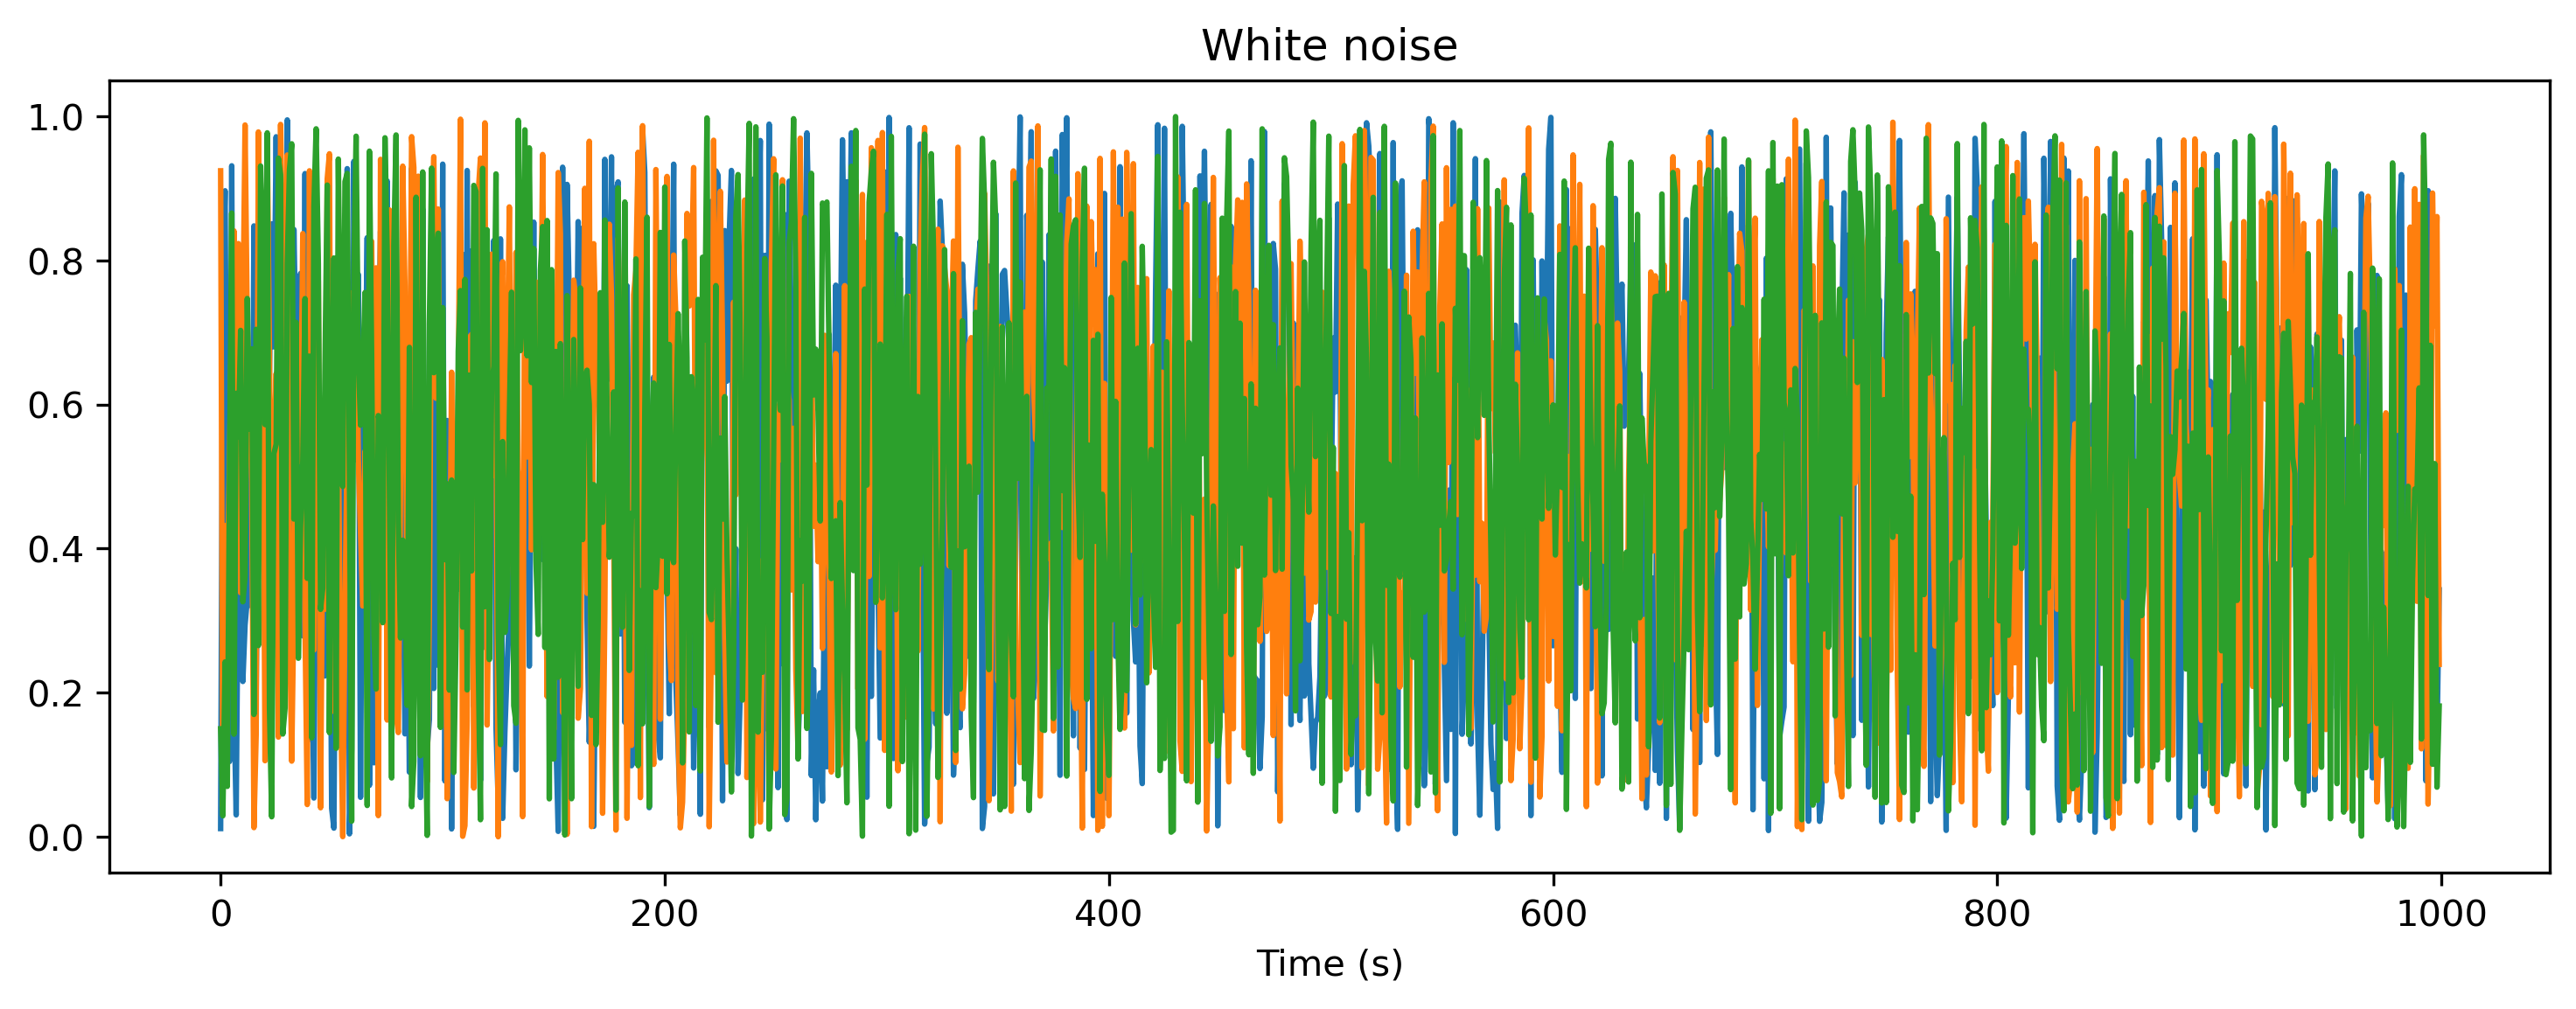

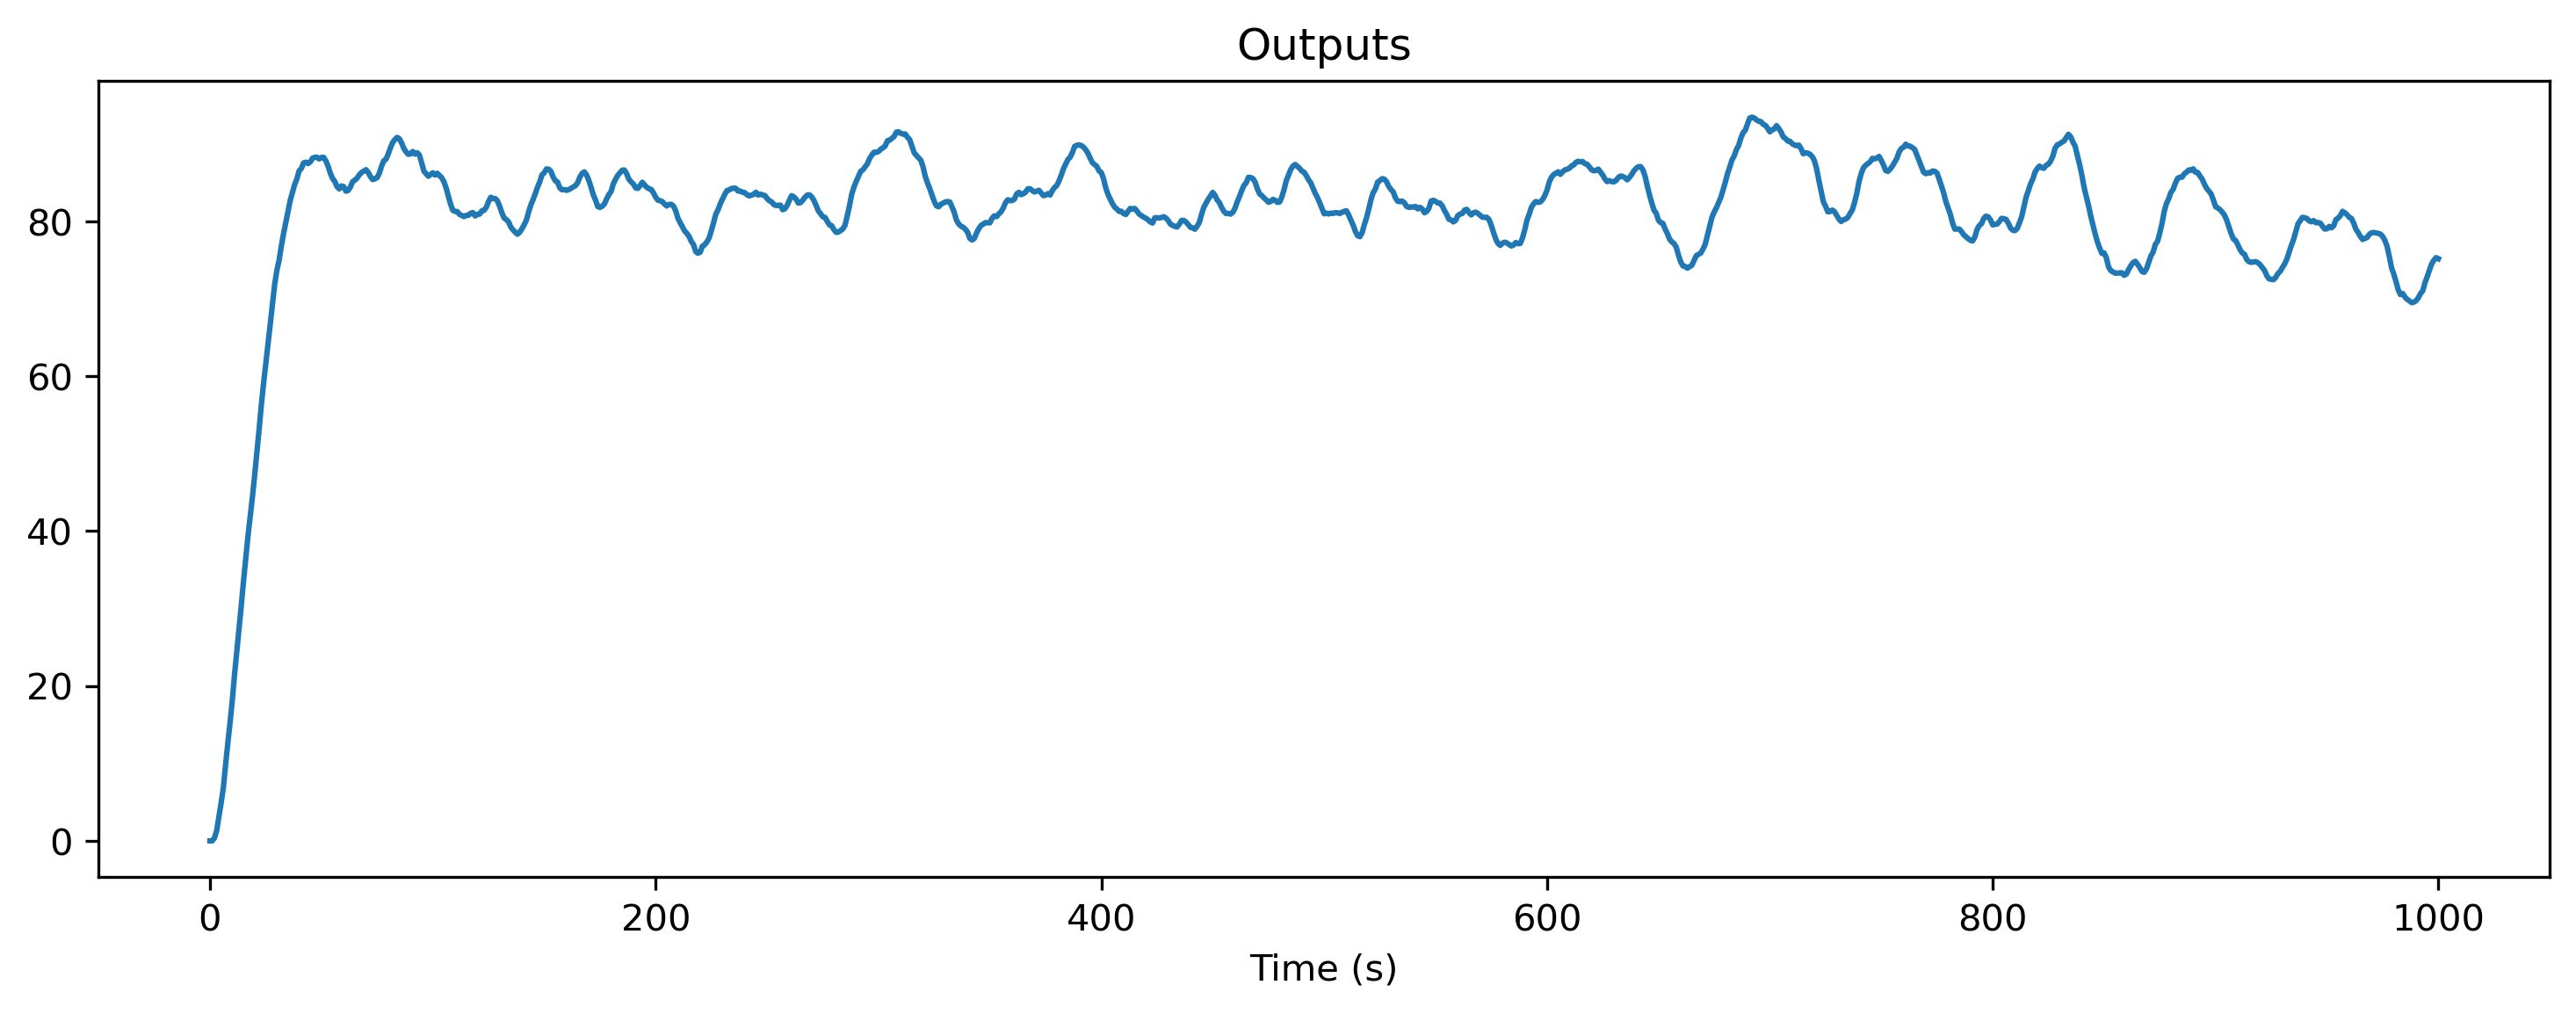

In [9]:
# - Generate some white noise input
ts_input = TSContinuous.from_clocked(np.random.rand(1000, Nin),
                                     name = 'White noise',
                                     dt = dt, periodic = True,
                                    )
print('Input:', ts_input)
ts_input.plot()

# - Evolve the TimedModule with the input
ts_output, _, rec = tmod(ts_input)

# - Display the output
print('Output:', ts_output)
plt.figure()
ts_output.plot();

## Building a network using internal `Module` s

In [10]:
# - Import the base class and a Module to use as a submodule
from rockpool.nn.modules import TimedModule
from rockpool.parameters import Parameter
from rockpool.nn.modules import RateEulerJax
from rockpool import TimeSeries

# - Define a new TimedModule
class ffwd_tmod_net2(TimedModule):
    # - Provide an `__init__` method to specify required parameters and modules
    #   Here you check, define and initialise whatever parameters and
    #   state you need for your module.
    def __init__(self,
                 shape,
                 *args,
                 **kwargs,
                ):
        # - Call superclass initialisation
        #   This is always required for a `Module` class
        super().__init__(shape = shape, *args, **kwargs)

        # - Specify weights attributes
        #   We need weights matrices for our layer weights.
        #   We specify the shapes explicitly, and provide an initialisation function.
        #   We also specify a family for the parameter, "weights". This is used to
        #   query parameters conveniently, and is a good idea to provide.
        self.w0 = Parameter(shape = self.shape[0:2],
                            init_func = lambda s: np.zeros(s),
                            family = 'weights',
                            )

        self.w1 = Parameter(shape = self.shape[1:3],
                            init_func = lambda s: np.zeros(s),
                            family = 'weights',
                            )
        
        # - Specify and add submodules
        #   These will be the neurons in our layer, to receive the weighted
        #   input signals. These sub-modules will be automatically configured
        #   internally, to specify the required state and parameters
        self.neurons0 = RateEulerJax(self.shape[1])
        self.neurons1 = RateEulerJax(self.shape[2])
        
    # - The `evolve` method contains the internal logic of your module
    #   `evolve` takes care of passing data in and out of the module,
    #   and between sub-modules if present.
    def evolve(self,
               ts_input: TimeSeries,
               duration: float,
               num_timesteps: int,
               record: bool = False,
               *args, **kwargs):
        # - First we need to rasterise the input time series.
        #   We can use the convenience method `_prepare_input()` for this
        time_base, input_raster, num_timesteps = self._prepare_input(
            ts_input, duration, num_timesteps
        )
        
        # - Pass input data through the input weights
        x0 = input_raster @ self.w0
        
        # - Pass the signals through the neurons
        x1, _, _ = self.neurons0(x0)
        
        # - Second layer weights
        x2 = x1 @ self.w1
        
        # - Second layer neurons
        x3, _, _ = self.neurons1(x2)
        
        # - We need to re-wrap the output raster as a TimeSeries object
        #   To do this we can use the convenience method `_gen_timeseries()`
        output_ts = self._gen_timeseries(x3)
        
        # - Return the module output
        return output_ts, {}, {}

In [11]:
# - Instantiate the module
tmod = ffwd_tmod_net2((Nin, 5, 7, Nout), dt = dt)
print(tmod)

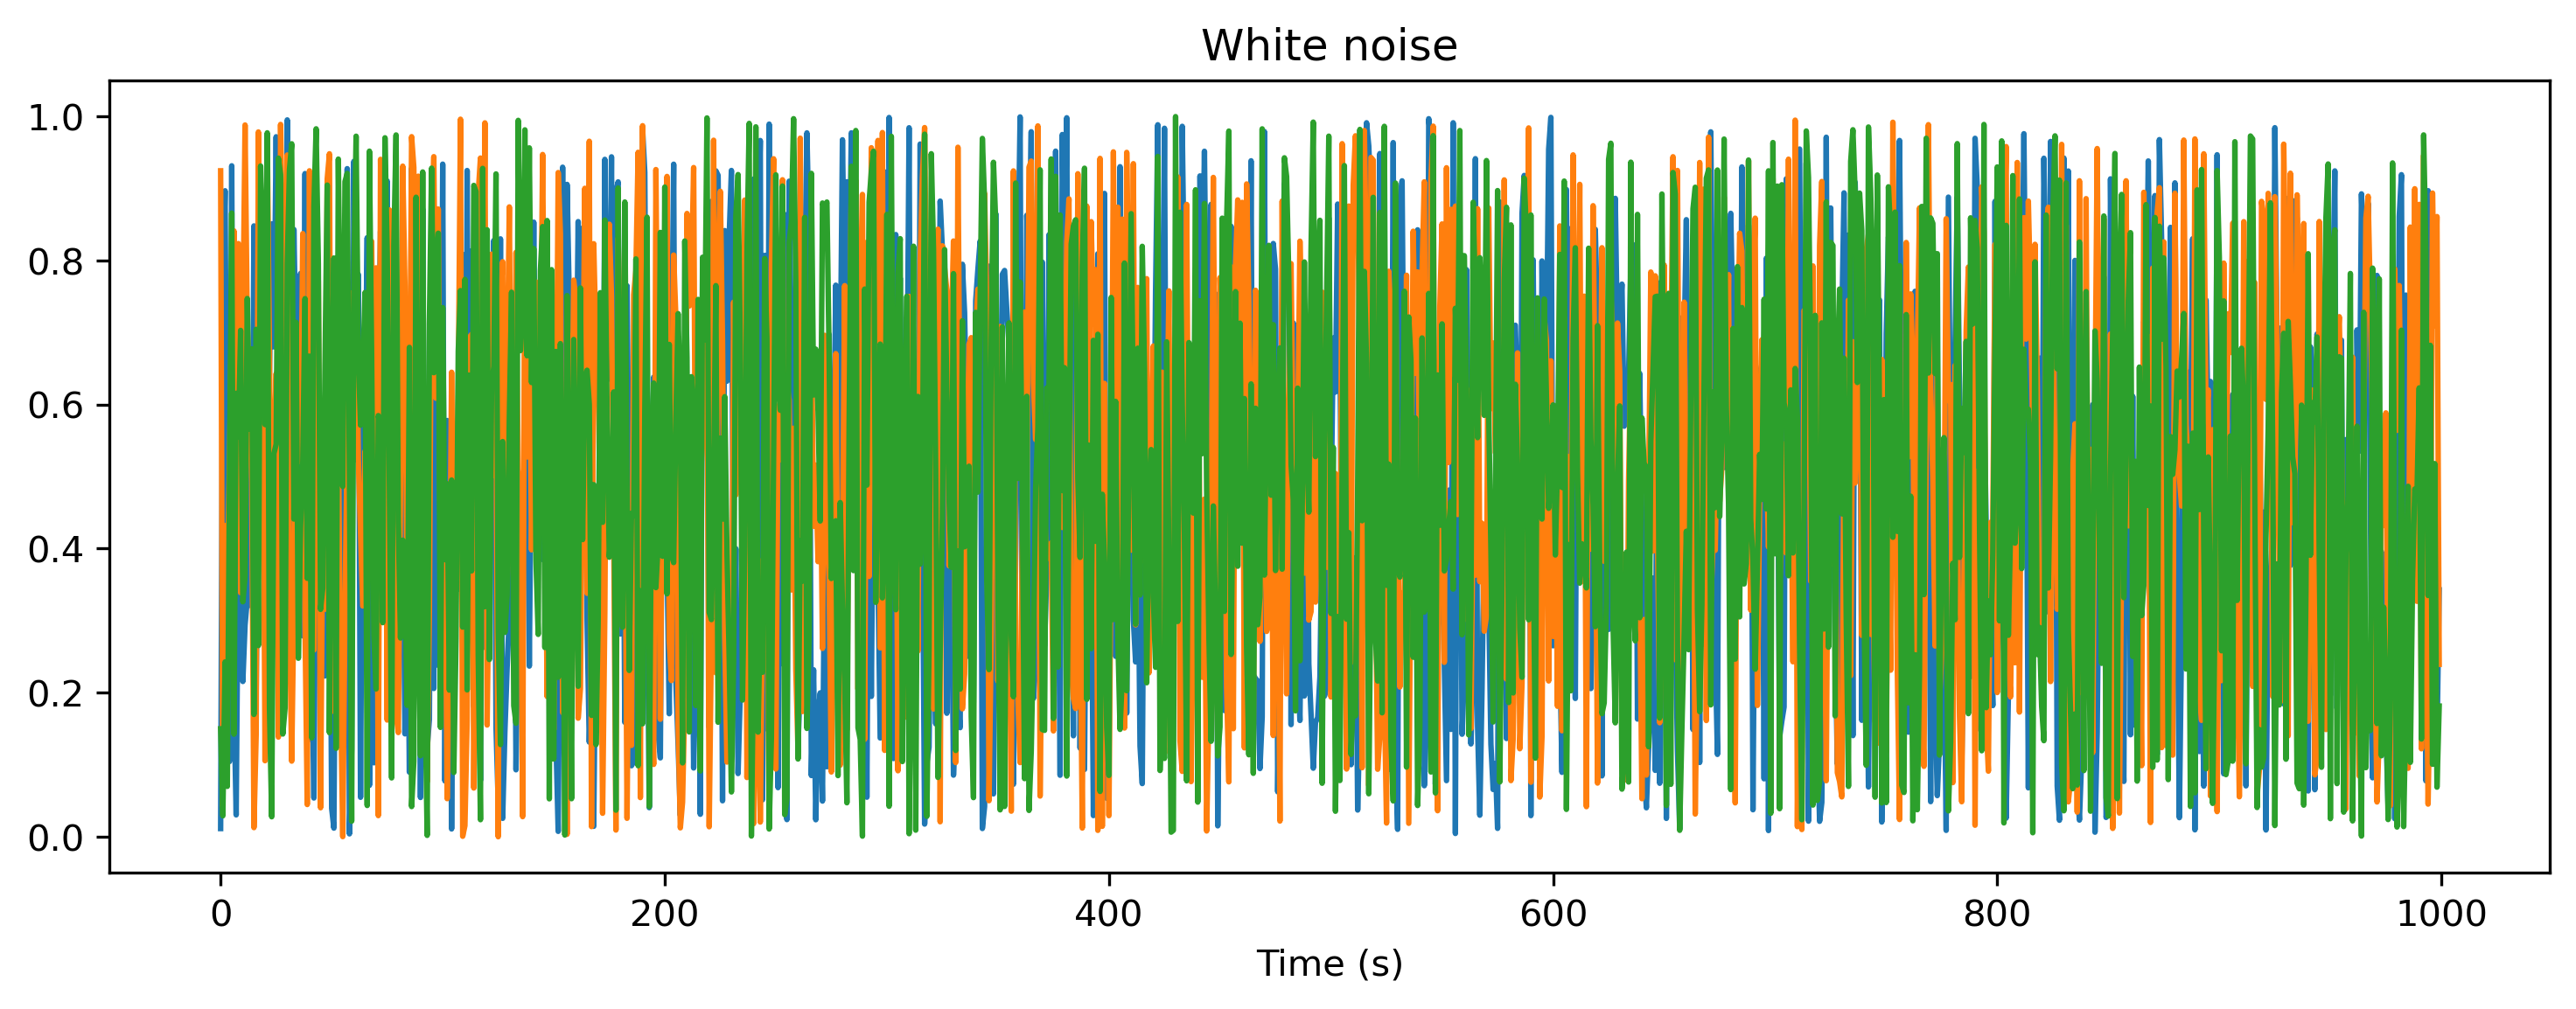

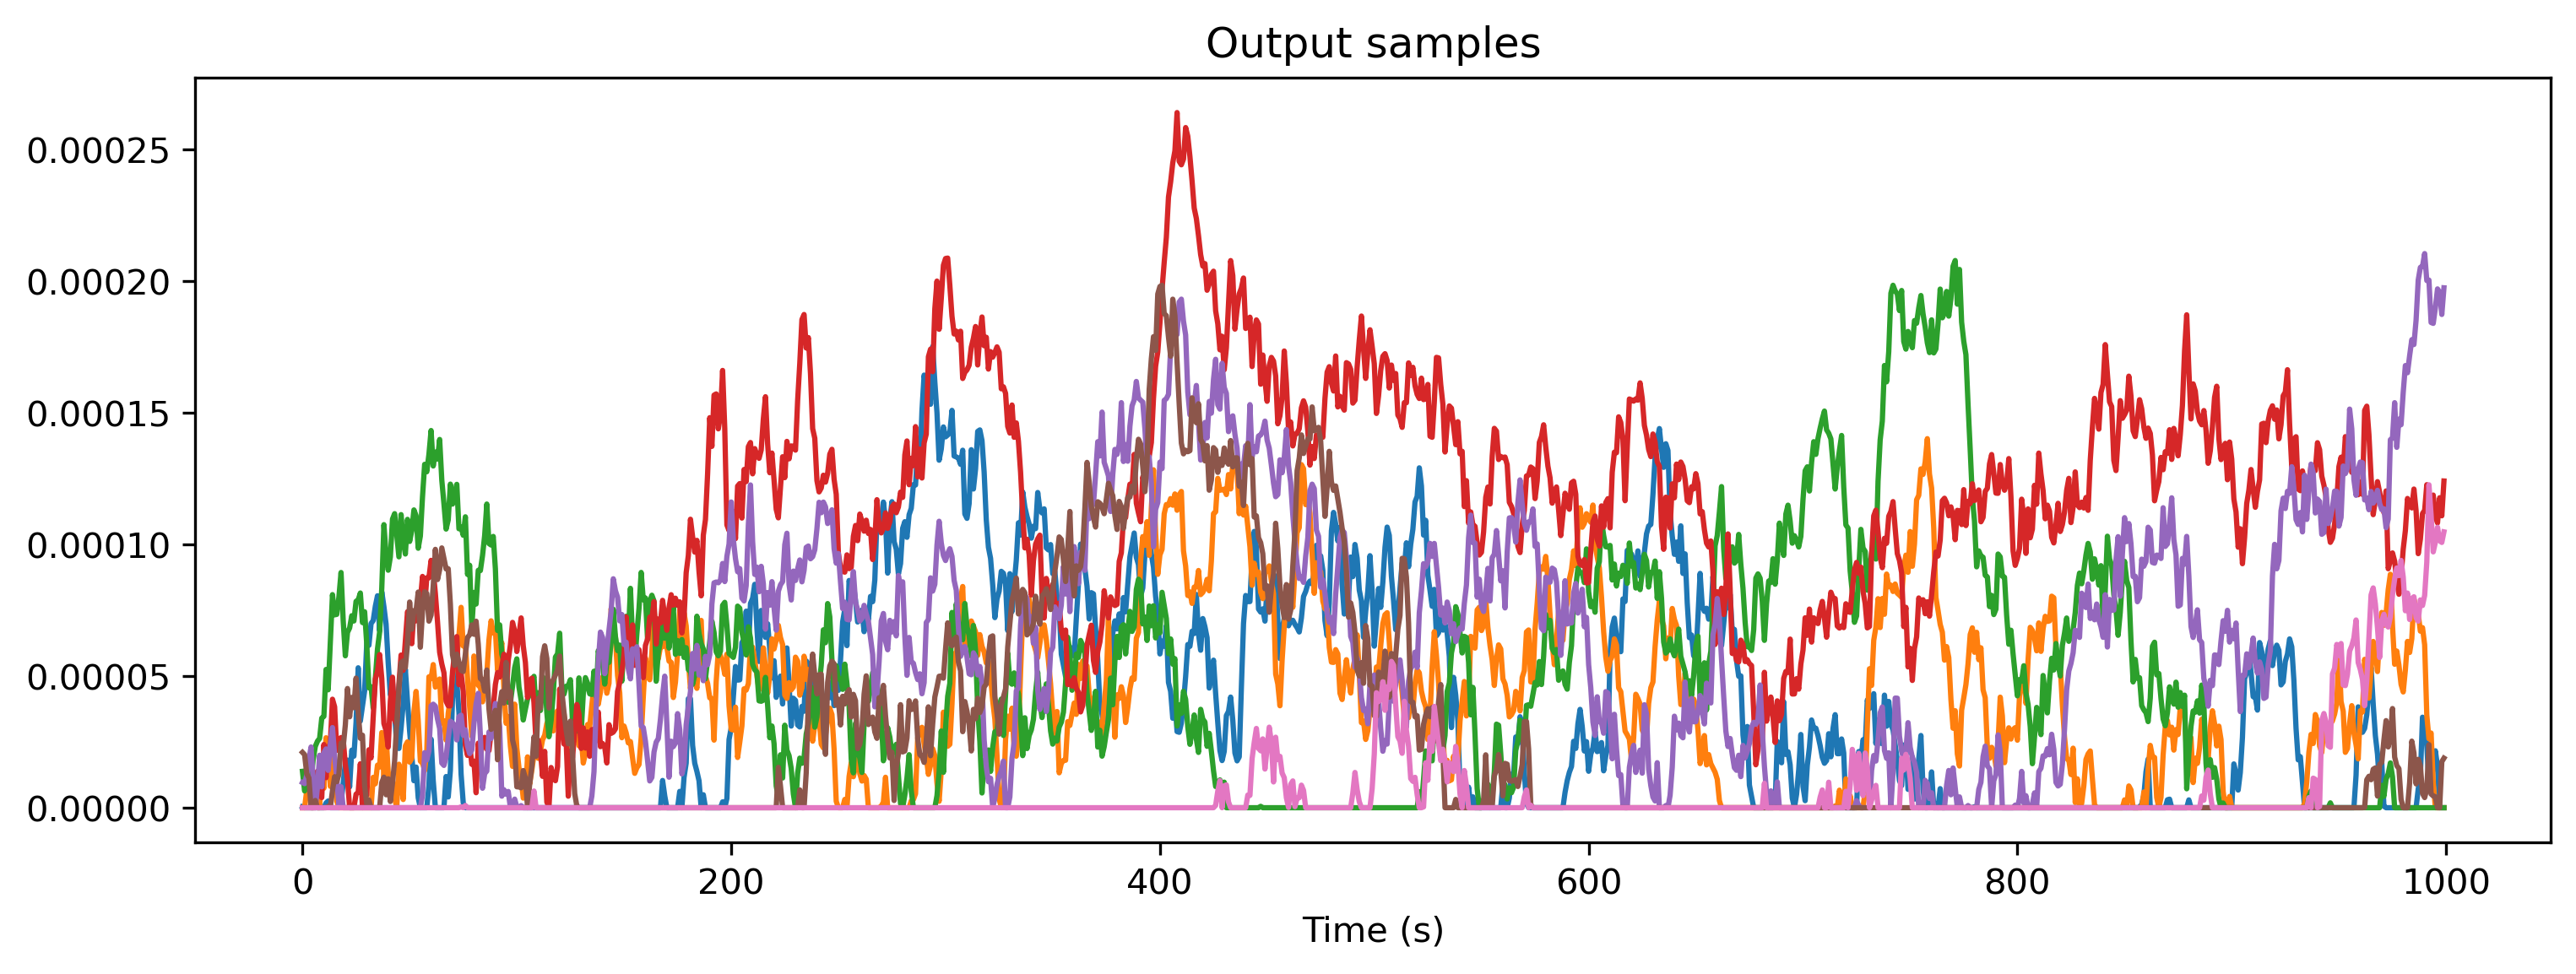

In [12]:
print('Input:', ts_input)
ts_input.plot()

# - Evolve the TimedModule with the input
ts_output, _, rec = tmod(ts_input)

# - Display the output
print('Output:', ts_output)
plt.figure()
ts_output.plot();

## Converting a low-level API `Module` to a high-level API `TimedModule`

In [13]:
# - Import the converter class
from rockpool.nn.modules.timed_module import TimedModuleWrapper
from rockpool.nn.modules import RateEulerJax

# - Generate a module and wrap as a TimedModule
mod = RateEulerJax(4)
tmod = TimedModuleWrapper(mod)
print(tmod)

In [14]:
# - Use the conversion method
from rockpool.nn.modules import RateEulerJax

# - Generate a module and wrap as a TimedModule
tmod = RateEulerJax(4).timed()
print(tmod)

## `TimedModule` API reference

### High-level attributes and methods provided by `TimedModule`

### Low-level attributes and methods inherited from `Module`